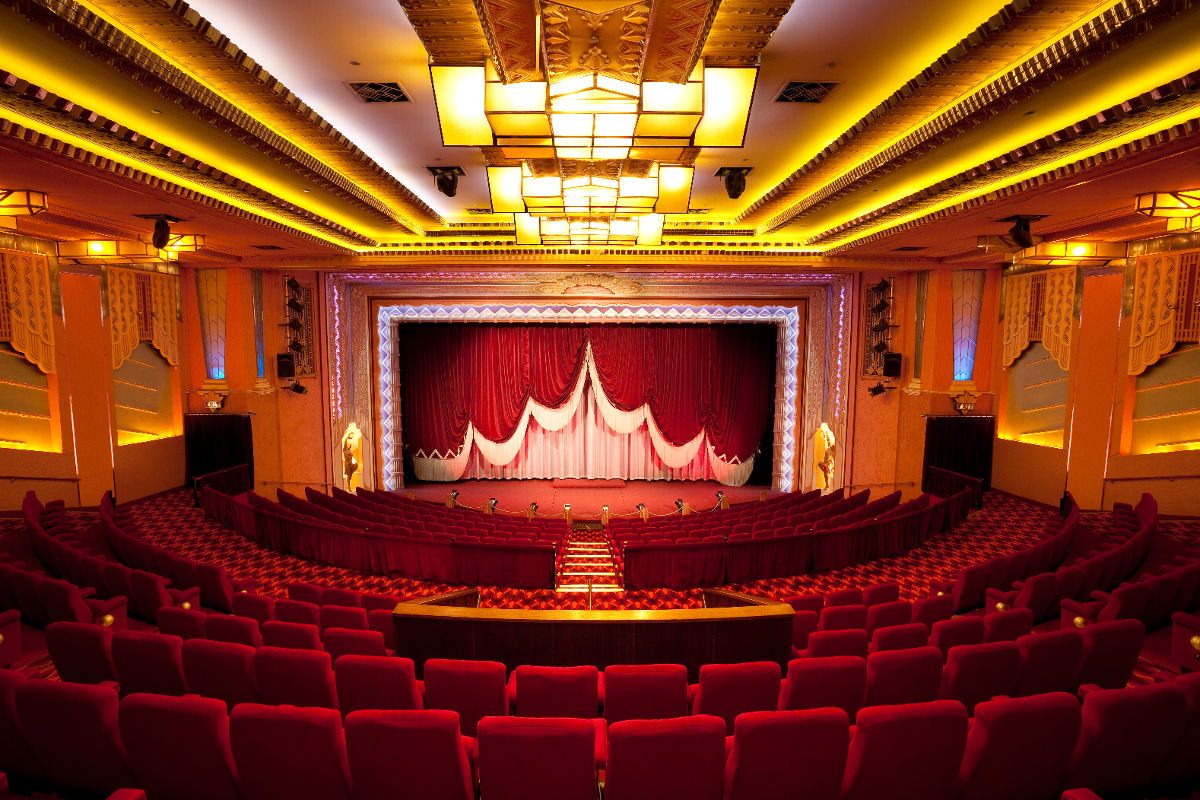

# Microsoft Movie Maximisation
## An analysis of past movie data to predict future movie success

by Shane Dowling
***

## Overview


Microsoft sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. This project will explore what types of films are currently doing the best at the box office. This project will then translate those findings into actionable insights that the head of Microsoft's new movie studio can use to help decide what type of films to create.

## Business Problem

This project will explore the movie market and offer recommendations for next steps in the expansion of Microsoft operations into the creation of new and exciting video content.

The problem being, that Microsoft admittedly do not know anything about creating movies.

Given that Microsoft is currently the most valuable public traded company in the world.  
The main goal in this exercise is to make movies that are profitable.

So, the main aim of this project will be to determine factors that affect profitability.

Once we have a measure for success,  
I will continue my analysis to examine three main categories that may affect profit.

* Genre
* Principal Contributors
* Release timing

but first we need to make sense of the data


## Data Understanding

This project draws on multiple datasets from a variety of sources.

### Box Office Mojo
* ### bom.movie_gross.csv.gz 
includes data for both Domestic and Foreign Gross profits.

### The Numbers
* ### tn.movie_budgets.csv.gz
includes data for Domestic and "Worldwide" profits.

The above two datasets is where i will extract profit data from.

### IMDB
I have also used numerous datasets from the IMDB database.  
These provide additional information which can then be compared as factors affecting profitability.

* ### imdb.title.basics.csv.gz
* ### imdb.title.principals.csv.gz

I have given a complete breakdown of the raw data   
including some of the methods i had to employ to access this data  
in the following Jupyter notebook:  
* Complete Dataset summary.ipynb

### Other useful data
In addition to the above datasets,  
I also needed to draw on additional data,   
in order to solve problems that arose,
I realised early on that i would need to calculate and adjust profit figures for inflation.
the additional data required to make these calculations was sourced from the following website:  
https://www.in2013dollars.com/  


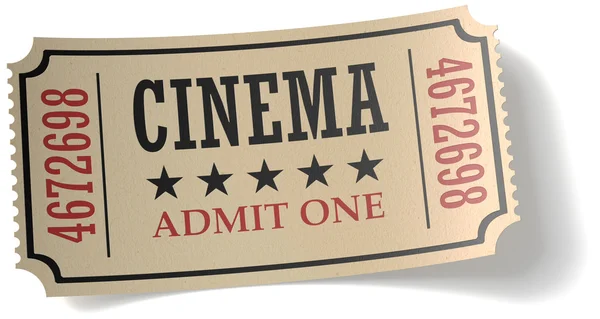

## Data Preparation

In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

pd.options.display.float_format = '{:.2f}'.format
# to stop large numbers appearing in scientific notation
# and to assist with inflation adjustment calculations

pd.options.mode.chained_assignment = None  # default='warn'
# to avoid "SettingWithCopyWarning"

### Preparing a Worldwide Gross dataset
#### Preparing BOM dataset 
As my primary measure of success for this project will be worldwide gross profit data,  
I wanted the largest dataset possible to work with,  
so my first aim was to merge the 'BOM' data and 'The Numbers' data to create a merged worldwide_gross dataset.

This dataset includes columns for "Domestic" and "Foreign" Gross profits.  
as part of this process, i will create an additional column in the data for "Worldwide" profits,  
which i calculate as the sum of "Domestic" and "Foreign" Gross profits.

In [2]:
dfbom = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
dfbom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


I will need to get rid of NaN values (especially as they are in the 'domestic' and 'foreign' gross columns)  
and ensure that the data is able to be merged  i.e. is of the same data type and has mergeable columns

In [3]:
dfbom = dfbom.dropna()
dfbom.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2007 entries, 0 to 3353
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           2007 non-null   object 
 1   studio          2007 non-null   object 
 2   domestic_gross  2007 non-null   float64
 3   foreign_gross   2007 non-null   object 
 4   year            2007 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 94.1+ KB


i'll need the 'foreign_gross' column to be numeric  

but:  
dfbom['foreign_gross'] = pd.to_numeric(dfbom['foreign_gross'])  

returns:  
ValueError: Unable to parse string "1,131.6" at position 1275

so first i have to run this:

In [4]:
dfbom = dfbom.replace(',','', regex=True)

In [5]:
dfbom['foreign_gross'] = pd.to_numeric(dfbom['foreign_gross'])
dfbom.dtypes

title              object
studio             object
domestic_gross    float64
foreign_gross     float64
year                int64
dtype: object

Finally, in order to work 'The Numbers' dataset  
a worldwide_gross figure would be useful  
this can be calculated by adding the 'domestic_gross' + 'foreign_gross' columns

In [6]:
dfbom['worldwide_gross'] = dfbom['domestic_gross'] + dfbom['foreign_gross']
dfbom.head(2)

,title,studio,domestic_gross,foreign_gross,year,worldwide_gross
0,Toy Story 3,BV,415000000.00,652000000.00,2010,1067000000.00
1,Alice in Wonderland (2010),BV,334200000.00,691300000.00,2010,1025500000.00


### Preparing 'The Numbers' dataset
This dataset already had the "Worldwide_Gross" data column,   
so there wasnt much cleaning that needed to be done.  
But there was a bit of work to ensure that datasets match, and formatting was readable.

In [7]:
dftn =  pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
dftn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


there doesnt appear to be any missing data  
but i will want those last three datatypes changed to numeric.

In [8]:
dftn.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"


from my previous experience with cleaning dfbom,  
i know that those commas and dollar signs are going to cause problems too  
so i run the following code

In [9]:
# replace values only in selected columns
dftn[dftn.columns[3:]] = dftn[dftn.columns[3:]].replace('[\$,]', '', regex=True).astype(float)
dftn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5782 non-null   int64  
 1   release_date       5782 non-null   object 
 2   movie              5782 non-null   object 
 3   production_budget  5782 non-null   float64
 4   domestic_gross     5782 non-null   float64
 5   worldwide_gross    5782 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 271.2+ KB


In [10]:
dftn

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000.00,760507625.00,2776345279.00
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.00,241063875.00,1045663875.00
2,3,"Jun 7, 2019",Dark Phoenix,350000000.00,42762350.00,149762350.00
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.00,459005868.00,1403013963.00
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.00,620181382.00,1316721747.00
...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,7000.00,0.00,0.00
5778,79,"Apr 2, 1999",Following,6000.00,48482.00,240495.00
5779,80,"Jul 13, 2005",Return to the Land of Wonders,5000.00,1338.00,1338.00
5780,81,"Sep 29, 2015",A Plague So Pleasant,1400.00,0.00,0.00


it looks like there are also some zeros that may cause problems later  
so I'll remove the rows with zeros in those columns with the following:  

In [11]:
dftn = dftn[(dftn[['domestic_gross','worldwide_gross']] != 0).all(axis=1)]

In [12]:
dftn

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000.00,760507625.00,2776345279.00
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.00,241063875.00,1045663875.00
2,3,"Jun 7, 2019",Dark Phoenix,350000000.00,42762350.00,149762350.00
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.00,459005868.00,1403013963.00
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.00,620181382.00,1316721747.00
...,...,...,...,...,...,...
5775,76,"May 26, 2006",Cavite,7000.00,70071.00,71644.00
5776,77,"Dec 31, 2004",The Mongol King,7000.00,900.00,900.00
5778,79,"Apr 2, 1999",Following,6000.00,48482.00,240495.00
5779,80,"Jul 13, 2005",Return to the Land of Wonders,5000.00,1338.00,1338.00


in order to merge with the BOM dataset, it would be useful to change the name of the 'movie' column

In [13]:
dftn = dftn.rename(columns={'movie': 'title'})
dftn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5234 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5234 non-null   int64  
 1   release_date       5234 non-null   object 
 2   title              5234 non-null   object 
 3   production_budget  5234 non-null   float64
 4   domestic_gross     5234 non-null   float64
 5   worldwide_gross    5234 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 286.2+ KB


### Merging worldwide gross datasets

In [14]:
wwgross = dftn.merge(dfbom, on='title', how='outer')
wwgross

,id,release_date,title,production_budget,domestic_gross_x,worldwide_gross_x,studio,domestic_gross_y,foreign_gross,year,worldwide_gross_y
0,1.00,"Dec 18, 2009",Avatar,425000000.00,760507625.00,2776345279.00,NaN,NaN,NaN,NaN,NaN
1,2.00,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.00,241063875.00,1045663875.00,BV,241100000.00,804600000.00,2011.00,1045700000.00
2,3.00,"Jun 7, 2019",Dark Phoenix,350000000.00,42762350.00,149762350.00,NaN,NaN,NaN,NaN,NaN
3,4.00,"May 1, 2015",Avengers: Age of Ultron,330600000.00,459005868.00,1403013963.00,BV,459000000.00,946400000.00,2015.00,1405400000.00
4,5.00,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.00,620181382.00,1316721747.00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
6174,NaN,NaN,I Still See You,NaN,NaN,NaN,LGF,1400.00,1500000.00,2018.00,1501400.00
6175,NaN,NaN,The Catcher Was a Spy,NaN,NaN,NaN,IFC,725000.00,229000.00,2018.00,954000.00
6176,NaN,NaN,Time Freak,NaN,NaN,NaN,Grindstone,10000.00,256000.00,2018.00,266000.00
6177,NaN,NaN,Reign of Judges: Title of Liberty - Concept Short,NaN,NaN,NaN,Darin Southa,93200.00,5200.00,2018.00,98400.00


this has created a few duplicated columns.  

* the worldwide_gross_x column from the dftn dataset, 
* and the worldwide_gross_y column from the dfbom dataset.  
** the dfbom figure in this column appears to be a rounded figure  

I decided to create a new column 'merged_wwgross', which will be the max value of the two compared gross figures.  
this way there will be a common value for title in the dataset, that is the most accurate value available for each row

In [15]:
wwgross["merged_wwgross"] = wwgross[["worldwide_gross_x", "worldwide_gross_y"]].max(axis=1)
wwgross.head(3)

,id,release_date,title,production_budget,domestic_gross_x,worldwide_gross_x,studio,domestic_gross_y,foreign_gross,year,worldwide_gross_y,merged_wwgross
0,1.00,"Dec 18, 2009",Avatar,425000000.00,760507625.00,2776345279.00,NaN,NaN,NaN,NaN,NaN,2776345279.00
1,2.00,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.00,241063875.00,1045663875.00,BV,241100000.00,804600000.00,2011.00,1045700000.00,1045700000.00
2,3.00,"Jun 7, 2019",Dark Phoenix,350000000.00,42762350.00,149762350.00,NaN,NaN,NaN,NaN,NaN,149762350.00


and i'll clear up some of the columns i dont need.

In [16]:
wwgross = wwgross[['title', 'merged_wwgross', 'release_date', 'year']]
wwgross

,title,merged_wwgross,release_date,year
0,Avatar,2776345279.00,"Dec 18, 2009",NaN
1,Pirates of the Caribbean: On Stranger Tides,1045700000.00,"May 20, 2011",2011.00
2,Dark Phoenix,149762350.00,"Jun 7, 2019",NaN
3,Avengers: Age of Ultron,1405400000.00,"May 1, 2015",2015.00
4,Star Wars Ep. VIII: The Last Jedi,1316721747.00,"Dec 15, 2017",NaN
...,...,...,...,...
6174,I Still See You,1501400.00,NaN,2018.00
6175,The Catcher Was a Spy,954000.00,NaN,2018.00
6176,Time Freak,266000.00,NaN,2018.00
6177,Reign of Judges: Title of Liberty - Concept Short,98400.00,NaN,2018.00


### Adjusting for inflation
I noted that this data was ranging over a period from 1915 to 2019 a period of just over 100 years.  
I realised that inflation would be a factor in comparing worldwide profits.  
so i had to find a way to adjust this figure for inflation.

First i'll need a year figure for every row of data.  
some rows of this merged data have 'year' values.
but most have a 'release_date'.  
i'll convert that to a year figure.

In [17]:
#convert 'release_date' to string so that it can be split
wwgross['release_date'] = wwgross['release_date'].astype(str)

In [18]:
#create two new columns including 'r_year' for the year of release
wwgross[['r_date', 'r_year']] = wwgross['release_date'].str.split(',', expand=True)
wwgross

,title,merged_wwgross,release_date,year,r_date,r_year
0,Avatar,2776345279.00,"Dec 18, 2009",NaN,Dec 18,2009
1,Pirates of the Caribbean: On Stranger Tides,1045700000.00,"May 20, 2011",2011.00,May 20,2011
2,Dark Phoenix,149762350.00,"Jun 7, 2019",NaN,Jun 7,2019
3,Avengers: Age of Ultron,1405400000.00,"May 1, 2015",2015.00,May 1,2015
4,Star Wars Ep. VIII: The Last Jedi,1316721747.00,"Dec 15, 2017",NaN,Dec 15,2017
...,...,...,...,...,...,...
6174,I Still See You,1501400.00,nan,2018.00,nan,None
6175,The Catcher Was a Spy,954000.00,nan,2018.00,nan,None
6176,Time Freak,266000.00,nan,2018.00,nan,None
6177,Reign of Judges: Title of Liberty - Concept Short,98400.00,nan,2018.00,nan,None


those 'None' values in the 'r_year' will cause problems and will need to be replaced

In [19]:
wwgross = wwgross.replace({None: np.nan})

In [20]:
wwgross['r_year'] = wwgross['r_year'].astype(float)
wwgross

,title,merged_wwgross,release_date,year,r_date,r_year
0,Avatar,2776345279.00,"Dec 18, 2009",NaN,Dec 18,2009.00
1,Pirates of the Caribbean: On Stranger Tides,1045700000.00,"May 20, 2011",2011.00,May 20,2011.00
2,Dark Phoenix,149762350.00,"Jun 7, 2019",NaN,Jun 7,2019.00
3,Avengers: Age of Ultron,1405400000.00,"May 1, 2015",2015.00,May 1,2015.00
4,Star Wars Ep. VIII: The Last Jedi,1316721747.00,"Dec 15, 2017",NaN,Dec 15,2017.00
...,...,...,...,...,...,...
6174,I Still See You,1501400.00,nan,2018.00,nan,NaN
6175,The Catcher Was a Spy,954000.00,nan,2018.00,nan,NaN
6176,Time Freak,266000.00,nan,2018.00,nan,NaN
6177,Reign of Judges: Title of Liberty - Concept Short,98400.00,nan,2018.00,nan,NaN


Now, similar to previously  
i will take the max of the two year columns to create one year column to calculate inflation from.

In [21]:
wwgross["infl_year"] = wwgross[["year", "r_year"]].max(axis=1)
wwgross

,title,merged_wwgross,release_date,year,r_date,r_year,infl_year
0,Avatar,2776345279.00,"Dec 18, 2009",NaN,Dec 18,2009.00,2009.00
1,Pirates of the Caribbean: On Stranger Tides,1045700000.00,"May 20, 2011",2011.00,May 20,2011.00,2011.00
2,Dark Phoenix,149762350.00,"Jun 7, 2019",NaN,Jun 7,2019.00,2019.00
3,Avengers: Age of Ultron,1405400000.00,"May 1, 2015",2015.00,May 1,2015.00,2015.00
4,Star Wars Ep. VIII: The Last Jedi,1316721747.00,"Dec 15, 2017",NaN,Dec 15,2017.00,2017.00
...,...,...,...,...,...,...,...
6174,I Still See You,1501400.00,nan,2018.00,nan,NaN,2018.00
6175,The Catcher Was a Spy,954000.00,nan,2018.00,nan,NaN,2018.00
6176,Time Freak,266000.00,nan,2018.00,nan,NaN,2018.00
6177,Reign of Judges: Title of Liberty - Concept Short,98400.00,nan,2018.00,nan,NaN,2018.00


I'll simplify it again,  
I will need the 'r_date' column later,  
so im going to keep that, and just the other columns i need for now.

In [22]:
wwgross = wwgross[['title', 'merged_wwgross', 'infl_year', 'r_date']]
wwgross

,title,merged_wwgross,infl_year,r_date
0,Avatar,2776345279.00,2009.00,Dec 18
1,Pirates of the Caribbean: On Stranger Tides,1045700000.00,2011.00,May 20
2,Dark Phoenix,149762350.00,2019.00,Jun 7
3,Avengers: Age of Ultron,1405400000.00,2015.00,May 1
4,Star Wars Ep. VIII: The Last Jedi,1316721747.00,2017.00,Dec 15
...,...,...,...,...
6174,I Still See You,1501400.00,2018.00,nan
6175,The Catcher Was a Spy,954000.00,2018.00,nan
6176,Time Freak,266000.00,2018.00,nan
6177,Reign of Judges: Title of Liberty - Concept Short,98400.00,2018.00,nan


so now i can calculate an adjustment for inflation multiplier  

In [23]:
wwgross.sort_values('infl_year')

,title,merged_wwgross,infl_year,r_date
3528,The Birth of a Nation,11000000.00,1915.00,Feb 8
4110,"20,000 Leagues Under the Sea",8000000.00,1916.00,Dec 24
5178,Over the Hill to the Poorhouse,3000000.00,1920.00,Sep 17
4365,Ben-Hur: A Tale of the Christ,9000000.00,1925.00,Dec 30
5128,The Big Parade,22000000.00,1925.00,Nov 19
...,...,...,...,...
1390,John Wick: Chapter 3 â Parabellum,256498033.00,2019.00,May 17
4104,MA,44300625.00,2019.00,May 31
1379,Rocketman,108642725.00,2019.00,May 31
3031,Miss Bala,15362298.00,2019.00,Feb 1


the dataset ranges from 1915 - 2019  
i found a calculator online at https://www.in2013dollars.com/  
so i downloaded that data into a csv lookup table

In [24]:
infl_df = pd.read_csv('lookupTables/inflation_data.csv')
infl_df

,year,amount,inflation rate
0,1915,1.00,0.01
1,1916,1.08,0.08
2,1917,1.27,0.17
3,1918,1.50,0.18
4,1919,1.71,0.15
...,...,...,...
105,2020,25.62,0.01
106,2021,26.83,0.05
107,2022,28.98,0.08
108,2023,30.17,0.04


I want to compare all $ values to their equivalent value in 2024  
the below creates an inflation multiplier for each year  
to adjust any dollar figure year, for the equivalent 2024 amount

In [25]:
infl_df.amount = round(30.54/infl_df.amount,4)
infl_df

,year,amount,inflation rate
0,1915,30.54,0.01
1,1916,28.28,0.08
2,1917,24.05,0.17
3,1918,20.36,0.18
4,1919,17.86,0.15
...,...,...,...
105,2020,1.19,0.01
106,2021,1.14,0.05
107,2022,1.05,0.08
108,2023,1.01,0.04


I'll rename these columns to facilitate merging,   
and so that they are more descriptive

In [26]:
infl_df.rename(columns={'year': 'infl_year','amount':'infl_multiplier'}, inplace=True)
infl_df.head(3)

,infl_year,infl_multiplier,inflation rate
0,1915,30.54,0.01
1,1916,28.28,0.08
2,1917,24.05,0.17


Now, i am ready to merge the inflation multiplier into the dataframe

In [27]:
wwgross_infl = wwgross.merge(infl_df, on='infl_year', how='left')
wwgross_infl

,title,merged_wwgross,infl_year,r_date,infl_multiplier,inflation rate
0,Avatar,2776345279.00,2009.00,Dec 18,1.44,0.00
1,Pirates of the Caribbean: On Stranger Tides,1045700000.00,2011.00,May 20,1.37,0.03
2,Dark Phoenix,149762350.00,2019.00,Jun 7,1.21,0.02
3,Avengers: Age of Ultron,1405400000.00,2015.00,May 1,1.30,0.00
4,Star Wars Ep. VIII: The Last Jedi,1316721747.00,2017.00,Dec 15,1.26,0.02
...,...,...,...,...,...,...
6174,I Still See You,1501400.00,2018.00,nan,1.23,0.02
6175,The Catcher Was a Spy,954000.00,2018.00,nan,1.23,0.02
6176,Time Freak,266000.00,2018.00,nan,1.23,0.02
6177,Reign of Judges: Title of Liberty - Concept Short,98400.00,2018.00,nan,1.23,0.02


and then I can add a column with a worldwide gross figure adjusted for inflation ('adj_wwgross')

In [28]:
wwgross_infl['adj_wwgross'] = wwgross_infl['merged_wwgross'] * wwgross_infl['infl_multiplier']
wwgross_infl

,title,merged_wwgross,infl_year,r_date,infl_multiplier,inflation rate,adj_wwgross
0,Avatar,2776345279.00,2009.00,Dec 18,1.44,0.00,3992106876.67
1,Pirates of the Caribbean: On Stranger Tides,1045700000.00,2011.00,May 20,1.37,0.03,1434072980.00
2,Dark Phoenix,149762350.00,2019.00,Jun 7,1.21,0.02,180703251.51
3,Avengers: Age of Ultron,1405400000.00,2015.00,May 1,1.30,0.00,1828706480.00
4,Star Wars Ep. VIII: The Last Jedi,1316721747.00,2017.00,Dec 15,1.26,0.02,1656830974.25
...,...,...,...,...,...,...,...
6174,I Still See You,1501400.00,2018.00,nan,1.23,0.02,1843719.20
6175,The Catcher Was a Spy,954000.00,2018.00,nan,1.23,0.02,1171512.00
6176,Time Freak,266000.00,2018.00,nan,1.23,0.02,326648.00
6177,Reign of Judges: Title of Liberty - Concept Short,98400.00,2018.00,nan,1.23,0.02,120835.20


I also adjusted the 'production_budget' column, as this will come in handy later.  

I'll finish by tidying up the columns

but before i do, this would be a good time for me to save the r_date information i need for later use.

In [29]:
r_date_wwgross_infl = wwgross_infl[['title', 'adj_wwgross', 'infl_year', 'r_date']]

and now i can tidy up just the columns i need for now.

In [30]:
wwgross_infl = wwgross_infl[['title', 'adj_wwgross', 'infl_year']]
wwgross_infl

,title,adj_wwgross,infl_year
0,Avatar,3992106876.67,2009.00
1,Pirates of the Caribbean: On Stranger Tides,1434072980.00,2011.00
2,Dark Phoenix,180703251.51,2019.00
3,Avengers: Age of Ultron,1828706480.00,2015.00
4,Star Wars Ep. VIII: The Last Jedi,1656830974.25,2017.00
...,...,...,...
6174,I Still See You,1843719.20,2018.00
6175,The Catcher Was a Spy,1171512.00,2018.00
6176,Time Freak,326648.00,2018.00
6177,Reign of Judges: Title of Liberty - Concept Short,120835.20,2018.00


In [31]:
wwgross_infl = wwgross_infl.astype({'infl_year': int})
wwgross_infl

,title,adj_wwgross,infl_year
0,Avatar,3992106876.67,2009
1,Pirates of the Caribbean: On Stranger Tides,1434072980.00,2011
2,Dark Phoenix,180703251.51,2019
3,Avengers: Age of Ultron,1828706480.00,2015
4,Star Wars Ep. VIII: The Last Jedi,1656830974.25,2017
...,...,...,...
6174,I Still See You,1843719.20,2018
6175,The Catcher Was a Spy,1171512.00,2018
6176,Time Freak,326648.00,2018
6177,Reign of Judges: Title of Liberty - Concept Short,120835.20,2018


In [32]:
wwgross_infl.sort_values('adj_wwgross')

,title,adj_wwgross,infl_year
5225,The Rise and Fall of Miss Thang,574.43,2008
5049,Higher Power,648.38,2018
5074,The Dark Hours,667.96,2005
5224,Bang,1036.35,1996
3935,Perrierâs Bounty,1171.21,2010
...,...,...,...
0,Avatar,3992106876.67,2009
3383,Star Wars Ep. IV: A New Hope,4003783855.63,1977
46,Titanic,4244176535.19,1997
4956,Bambi,5083665200.00,1942


At the end of all this, i have a larger dataset,   
and a nice starting point,   
with titles, and a worldwide gross profit figure adjusted for inflation.  
at the very least, i can do a sort, as above  
resulting in  a list of 6179 movie titles ranked in order of gross profits adjusted by inflation.

Those last five titles are hardly a surprise.

### Preparing to work with IMDB data
The imdb datasets have some data that will be useful to make some recommendations.  
Each of the IMDB datasets uses title_id references.  
It will be useful to merge the 'wwgross_infl' dataset  
with 'imdb.title.basics.csv.gz' dataset, which has both 'title_id' column, and a 'title' column, as well as some potentially useful genre information.

In [33]:
dfimdb3 =  pd.read_csv('zippedData/imdb.title.basics.csv.gz')
dfimdb3

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.00,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.00,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.00,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.00,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.00,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.00,NaN


I will merge on the original_title field, but will need to change the name first.

In [34]:
dfimdb3.rename(columns={'original_title': 'title'}, inplace=True)
dfimdb3

,tconst,primary_title,title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.00,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.00,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.00,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.00,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.00,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.00,NaN


In [35]:
id_wwgross_infl_genre = wwgross_infl.merge(dfimdb3, on='title', how='inner')
id_wwgross_infl_genre

,title,adj_wwgross,infl_year,tconst,primary_title,start_year,runtime_minutes,genres
0,Pirates of the Caribbean: On Stranger Tides,1434072980.00,2011,tt1298650,Pirates of the Caribbean: On Stranger Tides,2011,136.00,"Action,Adventure,Fantasy"
1,Dark Phoenix,180703251.51,2019,tt6565702,Dark Phoenix,2019,113.00,"Action,Adventure,Sci-Fi"
2,Avengers: Age of Ultron,1828706480.00,2015,tt2395427,Avengers: Age of Ultron,2015,141.00,"Action,Adventure,Sci-Fi"
3,Avengers: Infinity War,2515108797.60,2018,tt4154756,Avengers: Infinity War,2018,149.00,"Action,Adventure,Sci-Fi"
4,Justice League,827835570.00,2017,tt0974015,Justice League,2017,120.00,"Action,Adventure,Fantasy"
...,...,...,...,...,...,...,...,...
3491,Wildlife,3806800.00,2018,tt5929754,Wildlife,2018,105.00,Drama
3492,I Still See You,1843719.20,2018,tt2160105,I Still See You,2018,98.00,"Fantasy,Thriller"
3493,The Catcher Was a Spy,1171512.00,2018,tt4602066,The Catcher Was a Spy,2018,98.00,"Biography,Drama,War"
3494,Time Freak,326648.00,2018,tt6769280,Time Freak,2018,104.00,"Comedy,Drama,Romance"


## Preparing Genre data
Now, i can begin working with the genre data,   
but first i'll need to make sure its there for every record.

In [36]:
id_wwgross_infl_genre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3496 entries, 0 to 3495
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            3496 non-null   object 
 1   adj_wwgross      3496 non-null   float64
 2   infl_year        3496 non-null   int32  
 3   tconst           3496 non-null   object 
 4   primary_title    3496 non-null   object 
 5   start_year       3496 non-null   int64  
 6   runtime_minutes  3078 non-null   float64
 7   genres           3433 non-null   object 
dtypes: float64(2), int32(1), int64(1), object(4)
memory usage: 205.0+ KB


There are only a few records with no genre data,   
i'll need to clear these out.

In [37]:
id_wwgross_infl_genre = id_wwgross_infl_genre.dropna(subset = ['genres'])
id_wwgross_infl_genre.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3433 entries, 0 to 3495
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            3433 non-null   object 
 1   adj_wwgross      3433 non-null   float64
 2   infl_year        3433 non-null   int32  
 3   tconst           3433 non-null   object 
 4   primary_title    3433 non-null   object 
 5   start_year       3433 non-null   int64  
 6   runtime_minutes  3063 non-null   float64
 7   genres           3433 non-null   object 
dtypes: float64(2), int32(1), int64(1), object(4)
memory usage: 228.0+ KB


Now, some of these movies have multiple genres listed in the 'genres' column  
so i'll need to split and explode these  
to do that, I'll need to make sure the 'genre' column datatype is string

In [38]:
id_wwgross_infl_genre['genres'] = id_wwgross_infl_genre['genres'].astype(str)

Then i can split the genres using the comma

In [39]:
id_wwgross_infl_genre['genres'] = id_wwgross_infl_genre['genres'].str.split(',')

And now i can explode the field

In [40]:
id_wwgross_infl_genre = id_wwgross_infl_genre.explode('genres')
id_wwgross_infl_genre

,title,adj_wwgross,infl_year,tconst,primary_title,start_year,runtime_minutes,genres
0,Pirates of the Caribbean: On Stranger Tides,1434072980.00,2011,tt1298650,Pirates of the Caribbean: On Stranger Tides,2011,136.00,Action
0,Pirates of the Caribbean: On Stranger Tides,1434072980.00,2011,tt1298650,Pirates of the Caribbean: On Stranger Tides,2011,136.00,Adventure
0,Pirates of the Caribbean: On Stranger Tides,1434072980.00,2011,tt1298650,Pirates of the Caribbean: On Stranger Tides,2011,136.00,Fantasy
1,Dark Phoenix,180703251.51,2019,tt6565702,Dark Phoenix,2019,113.00,Action
1,Dark Phoenix,180703251.51,2019,tt6565702,Dark Phoenix,2019,113.00,Adventure
...,...,...,...,...,...,...,...,...
3494,Time Freak,326648.00,2018,tt6769280,Time Freak,2018,104.00,Comedy
3494,Time Freak,326648.00,2018,tt6769280,Time Freak,2018,104.00,Drama
3494,Time Freak,326648.00,2018,tt6769280,Time Freak,2018,104.00,Romance
3495,Antonio Lopez 1970: Sex Fashion & Disco,89889.60,2018,tt5792490,Antonio Lopez 1970: Sex Fashion & Disco,2017,95.00,Biography


And just to finalise preparing this dataset, i'll reduce it down to just the columns i need.

In [41]:
id_wwgross_infl_genre = id_wwgross_infl_genre[['tconst', 'title', 'adj_wwgross', 'genres',]]
id_wwgross_infl_genre

,tconst,title,adj_wwgross,genres
0,tt1298650,Pirates of the Caribbean: On Stranger Tides,1434072980.00,Action
0,tt1298650,Pirates of the Caribbean: On Stranger Tides,1434072980.00,Adventure
0,tt1298650,Pirates of the Caribbean: On Stranger Tides,1434072980.00,Fantasy
1,tt6565702,Dark Phoenix,180703251.51,Action
1,tt6565702,Dark Phoenix,180703251.51,Adventure
...,...,...,...,...
3494,tt6769280,Time Freak,326648.00,Comedy
3494,tt6769280,Time Freak,326648.00,Drama
3494,tt6769280,Time Freak,326648.00,Romance
3495,tt5792490,Antonio Lopez 1970: Sex Fashion & Disco,89889.60,Biography


In [42]:
id_wwgross_infl_genre['adj_wwgross'] = id_wwgross_infl_genre['adj_wwgross'] / 1000000
id_wwgross_infl_genre = id_wwgross_infl_genre.rename(columns={'adj_wwgross': 'adj_wwgross(million)'})
id_wwgross_infl_genre

,tconst,title,adj_wwgross(million),genres
0,tt1298650,Pirates of the Caribbean: On Stranger Tides,1434.07,Action
0,tt1298650,Pirates of the Caribbean: On Stranger Tides,1434.07,Adventure
0,tt1298650,Pirates of the Caribbean: On Stranger Tides,1434.07,Fantasy
1,tt6565702,Dark Phoenix,180.70,Action
1,tt6565702,Dark Phoenix,180.70,Adventure
...,...,...,...,...
3494,tt6769280,Time Freak,0.33,Comedy
3494,tt6769280,Time Freak,0.33,Drama
3494,tt6769280,Time Freak,0.33,Romance
3495,tt5792490,Antonio Lopez 1970: Sex Fashion & Disco,0.09,Biography


## Preparing Principal data

The 'imdb.title.principals.csv.gz' dataset includes a category field,   
which outlines the principal roles within each movie.  
We dont have names yet,   
but we do have a "nconst" reference, so we can look those up later if we need them.

In [43]:
dfimdb5 =  pd.read_csv('zippedData/imdb.title.principals.csv.gz')
dfimdb5

,tconst,ordering,nconst,category,job,characters
0,tt0111414,1,nm0246005,actor,NaN,"[""The Man""]"
1,tt0111414,2,nm0398271,director,NaN,NaN
2,tt0111414,3,nm3739909,producer,producer,NaN
3,tt0323808,10,nm0059247,editor,NaN,NaN
4,tt0323808,1,nm3579312,actress,NaN,"[""Beth Boothby""]"
...,...,...,...,...,...,...
1028181,tt9692684,1,nm0186469,actor,NaN,"[""Ebenezer Scrooge""]"
1028182,tt9692684,2,nm4929530,self,NaN,"[""Herself"",""Regan""]"
1028183,tt9692684,3,nm10441594,director,NaN,NaN
1028184,tt9692684,4,nm6009913,writer,writer,NaN


Now to merge this, so that we can generate a list of movies with their principal roles.  


In [44]:
id_wwgross_infl_principals = id_wwgross_infl_genre.merge(dfimdb5, on='tconst', how='inner')
id_wwgross_infl_principals

,tconst,title,adj_wwgross(million),genres,ordering,nconst,category,job,characters
0,tt1298650,Pirates of the Caribbean: On Stranger Tides,1434.07,Action,10,nm0694627,writer,"novel ""On Stranger Tides",NaN
1,tt1298650,Pirates of the Caribbean: On Stranger Tides,1434.07,Action,1,nm0000136,actor,NaN,"[""Jack Sparrow""]"
2,tt1298650,Pirates of the Caribbean: On Stranger Tides,1434.07,Action,2,nm0004851,actress,NaN,"[""Angelica""]"
3,tt1298650,Pirates of the Caribbean: On Stranger Tides,1434.07,Action,3,nm0574534,actor,NaN,"[""Blackbeard""]"
4,tt1298650,Pirates of the Caribbean: On Stranger Tides,1434.07,Action,4,nm0001691,actor,NaN,"[""Barbossa""]"
...,...,...,...,...,...,...,...,...,...
66636,tt5792490,Antonio Lopez 1970: Sex Fashion & Disco,0.09,Documentary,4,nm0159510,archive_footage,NaN,NaN
66637,tt5792490,Antonio Lopez 1970: Sex Fashion & Disco,0.09,Documentary,5,nm2615851,director,NaN,NaN
66638,tt5792490,Antonio Lopez 1970: Sex Fashion & Disco,0.09,Documentary,6,nm4333147,producer,producer,NaN
66639,tt5792490,Antonio Lopez 1970: Sex Fashion & Disco,0.09,Documentary,7,nm1756961,cinematographer,NaN,NaN


In [45]:
id_wwgross_infl_principals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66641 entries, 0 to 66640
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tconst                66641 non-null  object 
 1   title                 66641 non-null  object 
 2   adj_wwgross(million)  66641 non-null  float64
 3   genres                66641 non-null  object 
 4   ordering              66641 non-null  int64  
 5   nconst                66641 non-null  object 
 6   category              66641 non-null  object 
 7   job                   23146 non-null  object 
 8   characters            26873 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 4.6+ MB


In this case, we are just looking for category,  
and there is a category listed for every record.  
but it would be helpful to reduce down the columns to just those that i need.

In [46]:
id_wwgross_infl_principals = id_wwgross_infl_principals[['tconst', 'title', 'adj_wwgross(million)', 'nconst', 'category']]
id_wwgross_infl_principals.head(3)

,tconst,title,adj_wwgross(million),nconst,category
0,tt1298650,Pirates of the Caribbean: On Stranger Tides,1434.07,nm0694627,writer
1,tt1298650,Pirates of the Caribbean: On Stranger Tides,1434.07,nm0000136,actor
2,tt1298650,Pirates of the Caribbean: On Stranger Tides,1434.07,nm0004851,actress


In [47]:
print (id_wwgross_infl_principals['category'].unique())

['writer' 'actor' 'actress' 'director' 'producer' 'composer' 'editor'
 'cinematographer' 'self' 'production_designer' 'archive_sound'
 'archive_footage']


Some of these categories are a little unneccessary.  
I'll remove some of these...

In [48]:
id_wwgross_infl_principals = id_wwgross_infl_principals.drop(id_wwgross_infl_principals[id_wwgross_infl_principals['category'] == 'archive_footage'].index)
id_wwgross_infl_principals = id_wwgross_infl_principals.drop(id_wwgross_infl_principals[id_wwgross_infl_principals['category'] == 'archive_sound'].index)
id_wwgross_infl_principals = id_wwgross_infl_principals.drop(id_wwgross_infl_principals[id_wwgross_infl_principals['category'] == 'producer'].index)
# Microsoft will be the producer in this scenario, so we dont need to compare these
id_wwgross_infl_principals = id_wwgross_infl_principals.drop(id_wwgross_infl_principals[id_wwgross_infl_principals['category'] == 'self'].index)
# cameo appearances will most likely just create outliers

In [49]:
print (id_wwgross_infl_principals['category'].unique())

['writer' 'actor' 'actress' 'director' 'composer' 'editor'
 'cinematographer' 'production_designer']


Also, in this day and age, we shouldnt really be discriminating between "actors" and "actresses",  
indeed, it is possible that the data itself includes some female "actors"
so i will alter the data, so that all "actors" and "actresses" are just called "actors"

In [50]:
id_wwgross_infl_principals['category'].replace('actress', 'actor', inplace=True)

In [51]:
print (id_wwgross_infl_principals['category'].unique())

['writer' 'actor' 'director' 'composer' 'editor' 'cinematographer'
 'production_designer']


In [52]:
id_wwgross_infl_principals.to_csv('principals.csv')

### Preparing Release date timing data
In order to calculate good timing for the release of our movie,  
I'll need to revisit the 'r_date_wwgross_infl' dataset i hived off earlier

In [53]:
r_date_wwgross_infl

,title,adj_wwgross,infl_year,r_date
0,Avatar,3992106876.67,2009.00,Dec 18
1,Pirates of the Caribbean: On Stranger Tides,1434072980.00,2011.00,May 20
2,Dark Phoenix,180703251.51,2019.00,Jun 7
3,Avengers: Age of Ultron,1828706480.00,2015.00,May 1
4,Star Wars Ep. VIII: The Last Jedi,1656830974.25,2017.00,Dec 15
...,...,...,...,...
6174,I Still See You,1843719.20,2018.00,nan
6175,The Catcher Was a Spy,1171512.00,2018.00,nan
6176,Time Freak,326648.00,2018.00,nan
6177,Reign of Judges: Title of Liberty - Concept Short,120835.20,2018.00,nan


First I'll need to strip out those "nan" values.


In [54]:
r_date_wwgross_infl = r_date_wwgross_infl[r_date_wwgross_infl['r_date'].str.contains('nan')==False]
r_date_wwgross_infl.tail(3)

,title,adj_wwgross,infl_year,r_date
5231,Following,445132.20,1999.00,Apr 2
5232,Return to the Land of Wonders,2112.84,2005.00,Jul 13
5233,My Date With Drew,285881.84,2005.00,Aug 5


Now to tidy up that r_date field.  
I only need the month

In [55]:
r_date_wwgross_infl['r_month'] = r_date_wwgross_infl['r_date'].str[:3]
r_date_wwgross_infl

,title,adj_wwgross,infl_year,r_date,r_month
0,Avatar,3992106876.67,2009.00,Dec 18,Dec
1,Pirates of the Caribbean: On Stranger Tides,1434072980.00,2011.00,May 20,May
2,Dark Phoenix,180703251.51,2019.00,Jun 7,Jun
3,Avengers: Age of Ultron,1828706480.00,2015.00,May 1,May
4,Star Wars Ep. VIII: The Last Jedi,1656830974.25,2017.00,Dec 15,Dec
...,...,...,...,...,...
5229,Cavite,109622.48,2006.00,May 26,May
5230,The Mongol King,1469.88,2004.00,Dec 31,Dec
5231,Following,445132.20,1999.00,Apr 2,Apr
5232,Return to the Land of Wonders,2112.84,2005.00,Jul 13,Jul


And to tidy up just the columns i need.

In [56]:
r_date_wwgross_infl = r_date_wwgross_infl[['title', 'adj_wwgross', 'r_month']]
r_date_wwgross_infl

,title,adj_wwgross,r_month
0,Avatar,3992106876.67,Dec
1,Pirates of the Caribbean: On Stranger Tides,1434072980.00,May
2,Dark Phoenix,180703251.51,Jun
3,Avengers: Age of Ultron,1828706480.00,May
4,Star Wars Ep. VIII: The Last Jedi,1656830974.25,Dec
...,...,...,...
5229,Cavite,109622.48,May
5230,The Mongol King,1469.88,Dec
5231,Following,445132.20,Apr
5232,Return to the Land of Wonders,2112.84,Jul


In [57]:
r_date_wwgross_infl['adj_wwgross'] = r_date_wwgross_infl['adj_wwgross'] / 1000000
r_date_wwgross_infl = r_date_wwgross_infl.rename(columns={'adj_wwgross': 'adj_wwgross(million)'})
r_date_wwgross_infl

,title,adj_wwgross(million),r_month
0,Avatar,3992.11,Dec
1,Pirates of the Caribbean: On Stranger Tides,1434.07,May
2,Dark Phoenix,180.70,Jun
3,Avengers: Age of Ultron,1828.71,May
4,Star Wars Ep. VIII: The Last Jedi,1656.83,Dec
...,...,...,...
5229,Cavite,0.11,May
5230,The Mongol King,0.00,Dec
5231,Following,0.45,Apr
5232,Return to the Land of Wonders,0.00,Jul


### Finalising preparation

I now have three main datasets that will be useful.
* #### id_wwgross_infl_genre
which includes Movie tiltles, the gross profit adjusted for inflation, and genre information

* #### id_wwgross_infl_principals  
which includes titles of movies, the gross profit adjusted for inflation, and the roles of principal members of the production team.

* #### r_date_wwgross_infl
which includes the title of the movie, the gross profit adjusted for inflation, and the month of release.


We are finally ready to begin modelling with this data.

## Data Modeling
Describe and justify the process for analyzing or modeling the data.

As stated in my introduction, I have three main areas that i want to investigate:
* Genre
* Principal Contributors
* Release date timing

I will break these down below.

### Genre data modelling
To begin my Genre data modelling,   
i will create a groupby table, based on the genre column

In [58]:
id_wwgross_infl_genre_groupby = id_wwgross_infl_genre.groupby('genres').mean('adj_wwgross')
id_wwgross_infl_genre_groupby

,adj_wwgross(million)
genres,
Action,263.00
Adventure,410.13
Animation,474.83
Biography,108.64
Comedy,154.44
Crime,93.69
Documentary,115.19
Drama,96.42
Family,306.36


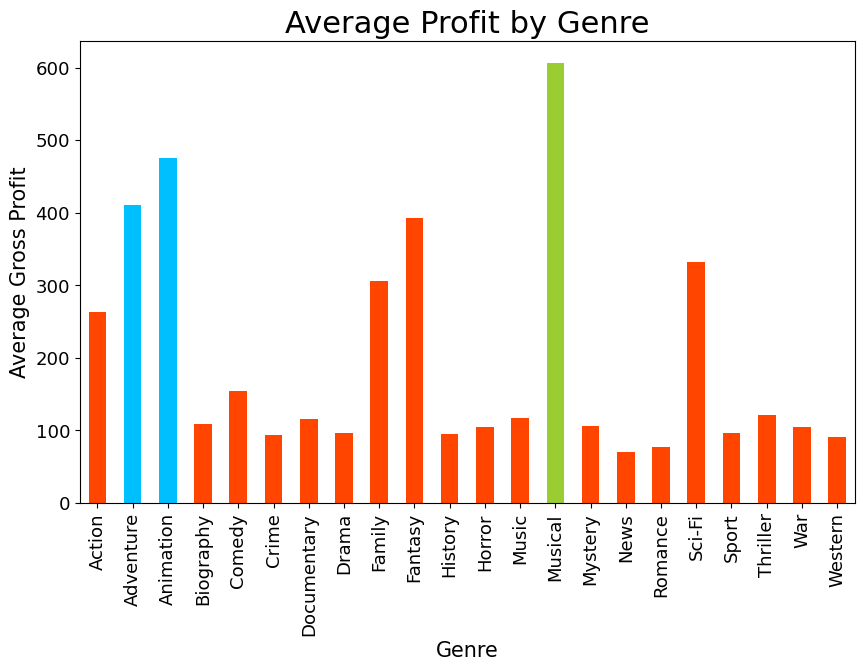

In [59]:
x_labels = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western']
colors = ["orangered", "deepskyblue", "deepskyblue", "orangered", "orangered", "orangered", "orangered", "orangered", "orangered", "orangered", "orangered", "orangered", "orangered", "yellowgreen", "orangered", "orangered", "orangered", "orangered", "orangered", "orangered", "orangered", "orangered" ]

ax = id_wwgross_infl_genre_groupby.unstack().plot(kind='bar', legend=False, figsize=(10,6), color=colors, fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Average Profit by Genre", fontsize=22)
ax.set_xlabel("Genre", fontsize=15);
ax.set_ylabel("Average Gross Profit", fontsize=15);
ax.set_xticklabels(x_labels)
plt.show()

The above graph gives a very clear indication of the success of different genres.
Musicals have historically proven to be the most successful genre by far, followed by Animation and Adventure movies.

### Principal Contributors modelling
Modelling for principal contributors was a similar process to genres.  
Once the data was prepared,   
I created a groupby table, based on the Principal Contributors "category"

In [60]:
id_wwgross_infl_principals_groupby = id_wwgross_infl_principals.groupby('category').mean('adj_wwgross')
id_wwgross_infl_principals_groupby

,adj_wwgross(million)
category,
actor,175.83
cinematographer,108.52
composer,123.70
director,183.46
editor,115.37
production_designer,100.79
writer,250.16


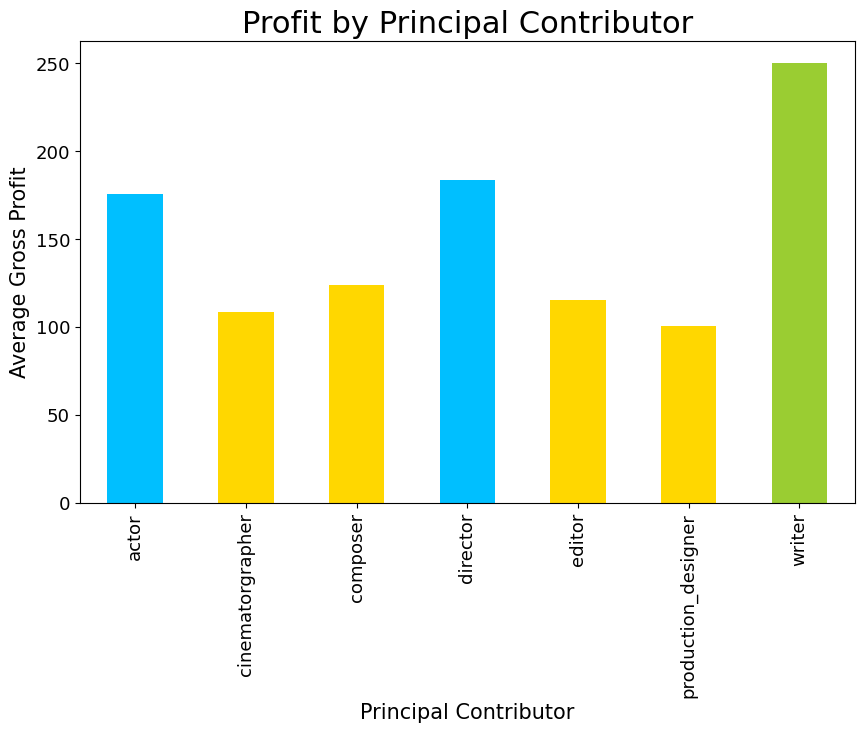

In [61]:
x_labels = ['actor', 'cinematorgrapher', 'composer', 'director', 'editor', 'production_designer', 'writer']
colors = [ "deepskyblue", "gold", "gold", "deepskyblue", "gold", "gold", "yellowgreen" ]

ax = id_wwgross_infl_principals_groupby.unstack().plot(kind='bar', legend=False, figsize=(10,6), color=colors, fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Profit by Principal Contributor", fontsize=22)
ax.set_xlabel("Principal Contributor", fontsize=15);
ax.set_ylabel("Average Gross Profit", fontsize=15);
ax.set_xticklabels(x_labels)
plt.show()

From the above graph,   
it is clear that the writer has the strongest influence on the profitability of a movie,  
followed by director, and then actor.

### Release Timing modelling

Once again,   
In order to calculate the best month to release a movie,  
I created a groupby table, based on the Principal Contributors "category"

In [62]:
r_date_wwgross_infl_groupby = r_date_wwgross_infl.groupby('r_month').mean('adj_wwgross')
r_date_wwgross_infl_groupby

,adj_wwgross(million)
r_month,
Apr,100.53
Aug,119.39
Dec,267.04
Feb,135.47
Jan,85.97
Jul,239.67
Jun,270.95
Mar,144.81
May,289.16


This will be useful data, but it has come out sorted by month alphabetically.
in order to sort these by month order, and to avoid a lot of wrangling trying to change a string to a date format.
i used the following code to create a dictionary.

In [63]:
month_dict = {'Jan':1,'Feb':2,'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}

and then sort by that dictionary

In [64]:
r_date_wwgross_infl_groupby = r_date_wwgross_infl_groupby.sort_values('r_month', key = lambda x : x.apply (lambda x : month_dict[x]))

In [65]:
r_date_wwgross_infl_groupby

,adj_wwgross(million)
r_month,
Jan,85.97
Feb,135.47
Mar,144.81
Apr,100.53
May,289.16
Jun,270.95
Jul,239.67
Aug,119.39
Sep,81.18


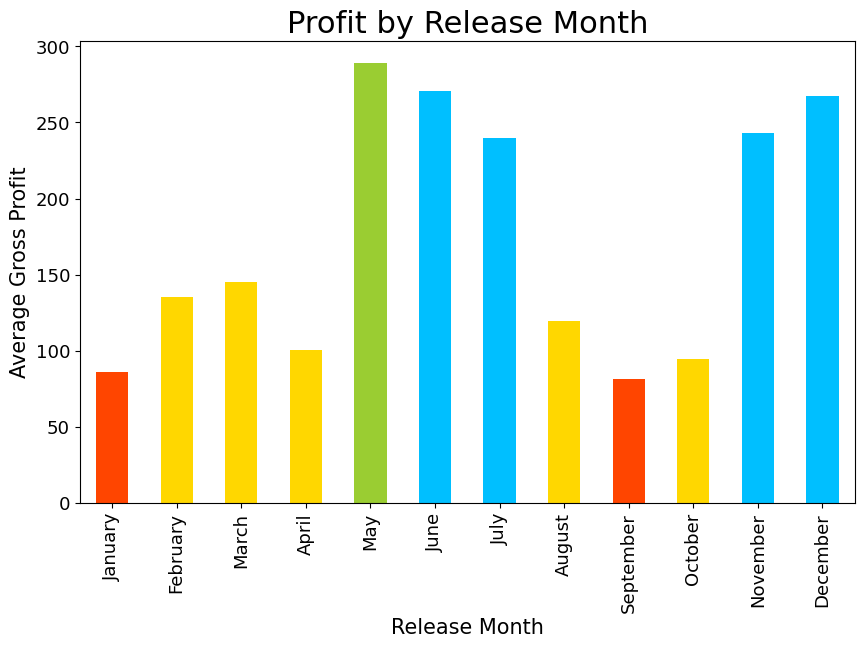

In [66]:
x_labels = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
colors = [ "orangered", "gold", "gold", "gold", "yellowgreen", "deepskyblue", "deepskyblue", "gold", "orangered", "gold", "deepskyblue", "deepskyblue" ]

ax = r_date_wwgross_infl_groupby.unstack().plot(kind='bar', legend=False, figsize=(10,6), color=colors, fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Profit by Release Month", fontsize=22)
ax.set_xlabel("Release Month", fontsize=15);
ax.set_ylabel("Average Gross Profit", fontsize=15);
ax.set_xticklabels(x_labels)
plt.show()

## Evaluation
Overall my analysis of the data has produced some interesting results.

Preparing the worldwide gross dataset was quite involved, but resulted in a larger dataset to work from.

Adjusting for inflation, also got quite complicated, and was a steep learning curve, however without this work, it would not have been possible to compare across all the data, which spanned a period of more than a hundred years.

The IMDB data provided a lot of useful comparison points.  

I made a deliberate decision to focus on profits as the key driver for this project.  
It might be interesting to investigate further the ratings given to movies by various critics which was available in datasets from both IMDB and from Rotten Tomatoes.  However, this did not necessarily influence the key driver of profit.  So i did not investigate these areas further.

My analysis has provided three good points for consideration for Microsoft as they begin to plan branching out into Movie Production.  There will be many more decision points along the way.

I will be happy to assist should they have any further data related queries.


## Conclusions

In conclusion,  As Microsoft prepares to branch out into Movie Production, I can offer the following recommendations.

1. To begin with focus on the Musical Genre.  
Traditionally, Musicals have been the highest grossing movies.  


2. Secondly, start with a great script.  
Writers have the highest influence overall on movie profitability. Good directors and Actors are also important, but start with a good writer.


3. Finally, aim for a release date in May.  
Movies released in May tend to have greater success than movies released in other months.    
June, December, November or July are also good,  
but avoid January or September.


#### disclaimer
Please remember that past performance is not necessarily a predictor of future success.  
All of the above data analysis has been run on past data.  
There is clearly a correlation that can be drawn from the data and these conclusions.
However this is not necessarily a causal relationship.